In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import autograd.numpy as np
from autograd import grad 

# element-wise gradient is a standard-alone function in v1.2
from autograd import elementwise_grad as egrad

import autograd.numpy.random as npr
from autograd.misc.flatten import flatten_func, flatten

from scipy.integrate import solve_ivp # for comparision
from scipy.optimize import minimize

In [2]:

# figure settings
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

In [3]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    
    return [998*y[0] + 1998*y[1], -999*y[0] - 1999*y[1]]

# Reference solution

In [4]:
t0, tmax = [0, 2]

#y0_list = [1, 0] # rapid increase and then decay. Can't solve by NN!
y0_list = [2, -1] # simply decay. Can be solved by NN easily

# Radau is an implicit solver. Explicit solver like RK45 needs far more time steps.
sol = solve_ivp(f, [t0, tmax], y0_list, method='Radau', rtol=1e-5)

In [5]:
sol.y.shape

(2, 13)

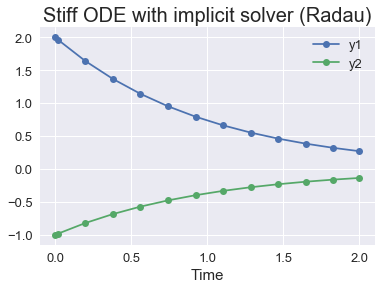

In [6]:
plt.plot(sol.t, sol.y[0], marker='o', label='y1')
plt.plot(sol.t, sol.y[1], marker='o', label='y2')
plt.legend()

plt.xlabel('Time')
plt.title('Stiff ODE with implicit solver (Radau)')
plt.savefig("stiff_implicit.png", dpi=300)

In [7]:
sol.t.size

13

## Explicit solver

In [8]:
sol_exp = solve_ivp(f, [t0, tmax], y0_list, method='RK45', rtol=1e-3)

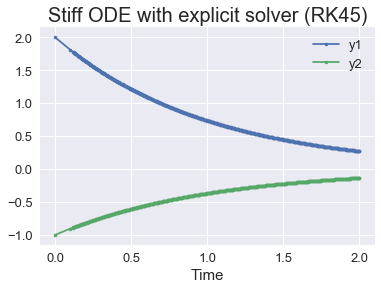

In [9]:
plt.plot(sol_exp.t, sol_exp.y[0], marker='.', label='y1')
plt.plot(sol_exp.t, sol_exp.y[1], marker='.', label='y2')
plt.legend()

plt.xlabel('Time')
plt.title('Stiff ODE with explicit solver (RK45)')
plt.savefig("stiff_explicit.png", dpi=300)

In [10]:
sol_exp.t.size

573

# Build NN

In [11]:
t = np.linspace(0, 2.0, 11).reshape(-1,1) # training points

In [12]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params1 = init_weights()
params2 = init_weights()
params_list = [params1, params2]
print([ p.shape for p in params1 ])

[(1, 10), (10,), (10, 1), (1,)]


In [13]:
def predict(params, t, y0, act=np.tanh):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(t, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0 + t*y
    
    return phi

In [14]:
predict(params1, t, y0_list[1]).shape # vectorized over t

(11, 1)

In [15]:
predict_dt = egrad(predict, argnum=1) # element-wise grad w.r.t t, 

In [16]:
predict_dt(params1, t, y0_list[1]).shape

(11, 1)

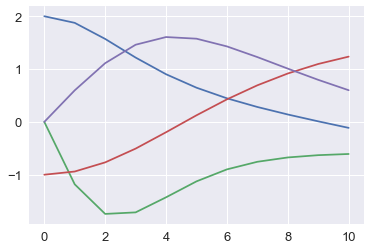

In [17]:
plt.plot(predict(params1, t, y0_list[0]))
plt.plot(predict_dt(params1, t, y0_list[0]))
plt.plot(predict(params2, t, y0_list[1]))
plt.plot(predict_dt(params2, t, y0_list[1]))

In [18]:
def loss_func(params_list, t, y0_list):
    
    
    y_pred_list = []
    dydt_pred_list = []
    for params, y0 in zip(params_list, y0_list):
        y_pred =  predict(params, t, y0)
        dydt_pred = predict_dt(params, t, y0)
        
        y_pred_list.append(y_pred)
        dydt_pred_list.append(dydt_pred)
        
    f_pred_list = f(t, y_pred_list)
    
    loss_total = 0.0
    for f_pred, dydt_pred in zip(f_pred_list, dydt_pred_list):
        loss = np.sum( (dydt_pred-f_pred)**2 )
        loss_total += loss
    
    return loss_total 

In [19]:
loss_func(params_list, t, y0_list)

39733751.01909028

In [20]:
flattened_params, unflat_func = flatten(params_list)

In [21]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    
    params_list = unflat_func(flattened_params) # recover
    
    # warning: global t and y0 are used
    return loss_func(params_list, t, y0_list)

In [22]:
loss_part(flattened_params)

39733751.01909028

In [23]:
loss_part_grad = grad(loss_part)

In [24]:
loss_part_grad(flattened_params).shape

(62,)

In [25]:
%%time
count = 0
def print_loss(x):
    global count
    if count %200 == 0:  
        print("iteration:", count, "loss: ", loss_part(x))
    count += 1
        
o = minimize(loss_part, x0=flattened_params, jac=loss_part_grad, 
             method="BFGS", callback=print_loss, 
             options = {'disp': True, 'maxiter': 1000})

iteration: 0 loss:  872709.868861
iteration: 200 loss:  0.00096364729455
iteration: 400 loss:  6.42076544227e-05
iteration: 600 loss:  1.05675224083e-05
         Current function value: 0.000005
         Iterations: 789
         Function evaluations: 934
         Gradient evaluations: 922
CPU times: user 5.71 s, sys: 71.5 ms, total: 5.78 s
Wall time: 5.88 s


In [26]:
loss_part(o.x)

5.2225453551111856e-06

In [27]:
print(o.fun, o.njev, o.nfev, '\n', o.message)

5.222545355111186e-06 922 934 
 Desired error not necessarily achieved due to precision loss.


In [28]:
params1_opt, params2_opt = unflat_func(o.x)

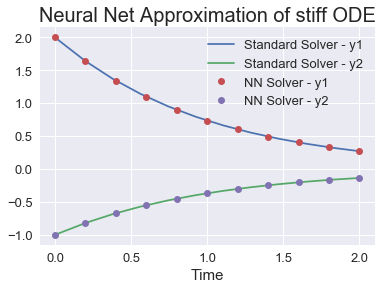

In [29]:
plt.plot(sol.t, sol.y[0], label='Standard Solver - y1')
plt.plot(sol.t, sol.y[1], label='Standard Solver - y2')

plt.plot(t, predict(params1_opt, t, y0_list[0]), 'o', label='NN Solver - y1')
plt.plot(t, predict(params2_opt, t, y0_list[1]), 'o', label='NN Solver - y2')

plt.legend()
plt.title('Neural Net Approximation of stiff ODE')
plt.xlabel('Time')
plt.savefig("stiff_ANN.png", dpi=300)

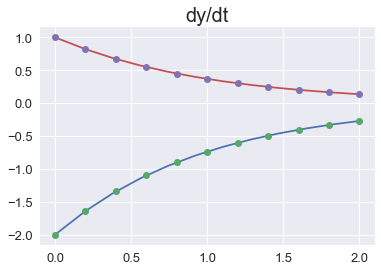

In [30]:
plt.plot(sol.t, f(sol.t, sol.y)[0])
plt.plot(t, predict_dt(params1_opt, t, y0_list[0]), 'o')

plt.plot(sol.t, f(sol.t, sol.y)[1])
plt.plot(t, predict_dt(params2_opt, t, y0_list[1]), 'o')

plt.title('dy/dt')